# Домашнее задание #1. Фильтр Калмана

Пусть имеется робот. Вектор состояния робота описывается следующими параметрами: 

1. $x$, $y$ - координаты робота,
2. $V_x$, $V_y$ - скорости.

При этом измерять мы умеем только координаты робота (что должно быть отражено в матрице $H$).

В этом домашнем задании вам необходимо: 
- правильно заполнить матрицы для фильтра Калмана.
- Для все трех приведенных экспериментов визуализируйте зависимость $x$, $y$, $V_x$, $V_y$ от времени.
- Для все трех приведенных экспериментов визуализируйте зависимость каждого компонента матрицы коэффициентов усиления ($K$) от времени. 
    - О чем говорит динамика изменения ее компонентов?
- Насколько уменьшается неопределенность скорости в результате каждого из экспериментов?

Ниже реализован класс, представляющий собой матрицу (как математический объект) и обпределяющий некоторые стандартные операции для нее. 

In [1]:
from math import *

class matrix:
    
    # implements basic operations of a matrix class
    
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0])
        if value == [[]]:
            self.dimx = 0
    
    def zero(self, dimx, dimy):
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx = dimx
            self.dimy = dimy
            self.value = [[0 for row in range(dimy)] for col in range(dimx)]
    
    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx = dim
            self.dimy = dim
            self.value = [[0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1
    
    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')
    
    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to add")
        else:
            # add if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res
    
    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to subtract")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res
    
    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise(ValueError, "Matrices must be m*n and n*p to multiply")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
            return res
    
    def transpose(self):
        # compute transpose
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res
    
    # Thanks to Ernesto E. Adorio for use of Cholesky and CholeskyInverse functions
    
    def Cholesky(self, ztol=1.0e-5):
        # Computes the upper triangular Cholesky factorization of
        # a positive definite matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise(ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(self.dimx)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res
    
    def CholeskyInverse(self):
        # Computes inverse of matrix given its Cholesky upper Triangular
        # decomposition of matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/tjj**2 - S/tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = -sum([self.value[i][k]*res.value[k][j] for k in range(i+1, self.dimx)])/self.value[i][i]
        return res
    
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res
    
    def __repr__(self):
        return repr(self.value)

In [2]:
k = list()
x_rem = list()
########################################

def filter(x, E):
    for n in range(len(measurements)):
        
        # prediction
        x = (F * x) + u
        E = F * E * F.transpose()

        # measurement update
        Z = matrix([measurements[n]])
        S = H * E * H.transpose() + R
        K = E * H.transpose() * S.inverse()
        k.append(K)
        x = x + (K * (Z.transpose() - (H * x)))
        x_rem.append(x)
        E = (I - (K * H)) * E
    
        print('x= ')
        x.show()
        print('P= ')
        E.show()

########################################

In [3]:
import numpy as np
#print("### First Experiment ###")
#measurements = [[5., 10.], [6., 8.], [7., 6.], [8., 4.], [9., 2.], [10., 0.], [11., -2.],  [12., -4.], [13., -6.], [14., -8.]]
#initial_xy = [4., 12.]

# print("### Second Experiment ###")
# measurements = [[1., 4.], [6., 0.], [11., -4.], [16., -8.], [21., -12], [26., -16]]
# initial_xy = [-4., 8.]

# print("### Third Experiment ###")
# measurements = [[1., 17.], [1., 15.], [1., 13.], [1., 11.], [1., 9], [1., 7]]
# initial_xy = [1., 19.]

initial_xy = [4., 12.]
v = [1, -2]
n = 20
noisу = 1
measurements = [initial_xy]
for i in range(n):
    xy = np.array(initial_xy) + np.array(v) * i +  np.random.normal(0,noisу,2)
    measurements.append(xy)

# for i in range(len(measurements)):
#     measurements[i] += np.random.normal(0,noisу,2)

print("init state: " + str(initial_xy))
print("measurements: " + str(measurements))

x = matrix([[initial_xy[0]], [initial_xy[1]], [0.], [0.]]) # initial robot state (location and velocity)
u = matrix([[0.], [0.], [0.], [0.]]) # external motion applied to the robot

init state: [4.0, 12.0]
measurements: [[4.0, 12.0], array([ 3.9647392 , 12.11347981]), array([4.60362019, 7.80999196]), array([6.78483421, 7.53225111]), array([8.40608973, 6.96555183]), array([7.55994122, 4.59200378]), array([6.84433654, 0.49522721]), array([ 8.76073734, -0.5246742 ]), array([11.39611435, -4.38133518]), array([13.58840525, -3.14159237]), array([12.33870052, -6.01700371]), array([13.06710431, -7.54107832]), array([13.22208743, -9.33220748]), array([ 16.12282683, -11.18216661]), array([ 18.06893728, -12.85200661]), array([ 18.63501967, -16.34631861]), array([ 19.96440296, -17.22338751]), array([ 21.41646533, -19.34136843]), array([ 21.66449276, -21.70537867]), array([ 22.68144813, -25.58793952]), array([ 24.49689494, -26.33710094])]


In [4]:
E = matrix([[0, 0, 0, 0], [0,0,0,0], [0,0,1000,0], [0,0,0,1000]])# initial uncertainty: 0. for positions x and y, 1000 for the two velocities
F = matrix([[1, 0, 1, 0],[0, 1,0,1],[0,0,1,0],[0,0,0,1]])# next state function: 4D
H = matrix([[1,0,0,0],[0,1,0,0]])# measurement function: reflect the fact that we observe x and y but not the two velocities
R = matrix([[1, 0],[0, 1]])# measurement uncertainty: use 2x2 matrix with 0.1 as main diagonal
I = matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])# 4D identity matrix

filter(x, E)

x= 
[4.0]
[12.0]
[0.0]
[0.0]
 
P= 
[0.9990009990011872, 0.0, 0.9990009990011872, 0.0]
[0.0, 0.9990009990011872, 0.0, 0.9990009990011872]
[0.9990009990011686, 0.0, 0.9990009990011686, 0.0]
[0.0, 0.9990009990011686, 0.0, 0.9990009990011686]
 
x= 
[3.971796999377075]
[12.09076569850979]
[-0.014101500311462286]
[0.045382849254894796]
 
P= 
[0.7998400319936294, 0.0, 0.3999200159968147, 0.0]
[0.0, 0.7998400319936294, 0.0, 0.3999200159968147]
[0.39992001599681104, 0.0, 0.19996000799840552, 0.0]
[0.0, 0.39992001599681104, 0.0, 0.19996000799840552]
 
x= 
[4.372903145154977]
[9.355246520794083]
[0.12430104838499137]
[-0.8815844930686332]
 
P= 
[0.6428112277694524, 0.0, 0.21427040925648413, 0.0]
[0.0, 0.6428112277694524, 0.0, 0.21427040925648413]
[0.21427040925648277, 0.0, 0.07142346975216093, 0.0]
[0.0, 0.21427040925648277, 0.0, 0.07142346975216093]
 
x= 
[5.7172328697770265]
[7.9715929395242044]
[0.4293082174442544]
[-1.0071017651189438]
 
P= 
[0.533315556148131, 0.0, 0.13332888903703274, 0.0]


F:\prog\Anaconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Визуализируйте зависимость $x$, $y$, $V_x$, $V_y$ от времени

In [5]:
import matplotlib.pyplot as plt

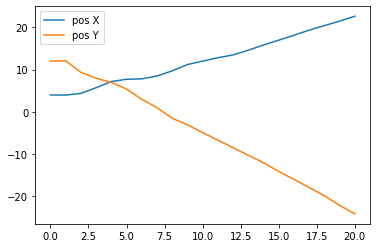

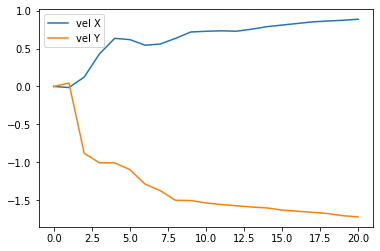

In [6]:
t = range(len(x_rem))
val = list();

for i in t:
    val.append(x_rem[i].value[0][0])
plt.plot(t, val, label = "pos X")
val.clear()

for i in t:
    val.append(x_rem[i].value[1][0])
plt.plot(t, val, label = "pos Y")
val.clear()

plt.legend()
plt.show()

for i in t:
    val.append(x_rem[i].value[2][0])
plt.plot(t, val, label = "vel X")
val.clear()

for i in t:
    val.append(x_rem[i].value[3][0])
plt.plot(t, val, label = "vel Y")
val.clear()

plt.legend()
plt.show()

Визуализируейте компоненты матрицы $K$ ниже 

In [7]:
for p in k:
    print(p)

[[0.9990009990009988, 0.0], [0.0, 0.9990009990009988], [0.9990009990009988, 0.0], [0.0, 0.9990009990009988]]
[[0.7998400319936301, 0.0], [0.0, 0.7998400319936301], [0.3999200159968113, 0.0], [0.0, 0.3999200159968113]]
[[0.6428112277694524, 0.0], [0.0, 0.6428112277694524], [0.21427040925648286, 0.0], [0.0, 0.21427040925648286]]
[[0.5333155561481308, 0.0], [0.0, 0.5333155561481308], [0.13332888903703205, 0.0], [0.0, 0.13332888903703205]]
[[0.45453719023290584, 0.0], [0.0, 0.45453719023290584], [0.09090743804658083, 0.0], [0.0, 0.09090743804658083]]
[[0.3956000483511174, 0.0], [0.0, 0.3956000483511174], [0.0659333413918527, 0.0], [0.0, 0.0659333413918527]]
[[0.3499975000178572, 0.0], [0.0, 0.3499975000178572], [0.049999642859693744, 0.0], [0.0, 0.049999642859693744]]
[[0.3137239523335669, 0.0], [0.0, 0.3137239523335669], [0.039215494041695775, 0.0], [0.0, 0.039215494041695775]]
[[0.28420952908937164, 0.0], [0.0, 0.28420952908937164], [0.031578836565485685, 0.0], [0.0, 0.031578836565485685

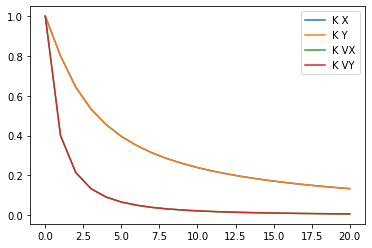

In [8]:
t = range(len(k))
val = list();

for i in t:
    val.append(k[i].value[0][0])
plt.plot(t, val, label = "K X")
val.clear()

for i in t:
    val.append(k[i].value[1][1])
plt.plot(t, val, label = "K Y")
val.clear()

for i in t:
    val.append(k[i].value[2][0])
plt.plot(t, val, label = "K VX")
val.clear()

for i in t:
    val.append(k[i].value[3][1])
plt.plot(t, val, label = "K VY")
val.clear()

plt.legend()
plt.show()

In [9]:
k.clear()
x_rem.clear()